In [ ]:
# import libraries
from IPython.display import clear_output
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

!pip install optuna
import optuna
from optuna.samplers import TPESampler

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

!pip install pyod

from pyod.models.copod import COPOD

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
clear_output()

# 1. Data Import

In [ ]:
# Train Data Import
train = pd.read_csv('train.csv')

# Num of cols, rows check
print(train.shape) 

# 학습 데이터
train.head()

(381109, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [ ]:
# Test Data Import
test = pd.read_csv('test.csv')

# Num of cols, rows check
print(test.shape)

# 테스트 데이터
test.head()

(127037, 11)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


Train 데이터는 총 354405명의 고객정보를 담고 있으며, 총 12개의 feature를 가지고 있다. Test data는 총 127037명의 고객정보를 우리의 target feature를 제외한 총 11개의 feature를 가지고 있다. 이로써, 우리의 target feature는 `Response`임을 알 수 있다. 

# Data Description
- id :	고객 고유번호
- Gender : 성별
- Age	: 나이
- Driving_License :	
  - 0 : 면허를 보유하지 않음
  - 1 : 면허를 보유중
- Region_Code :	고객 지역 고유코드
- Previously_Insured	: 
  - 1 : 이미 자동차보험 보유
  - 0 : 아직 자동차보험 미보유
- Vehicle_Age	: 자동차 년식
- Vehicle_Damage	: 
  - 1 : 과거에 자동차에 손상을 입힌적이 있음
  - 0 : 과거에 자동차에 손상을 입힌적이 없음
- Annual_Premium : 보험료
- PolicySalesChannel :	건강보험을 가입하게 된 경로
- Vintage	: 건강보험 보유기간
- Response	:
  - 1 : 관심있음
  - 0 : 관심없음

# Data Exploartion


## 1.결측치

In [ ]:
# Train info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [ ]:
# Test info
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    127037 non-null  int64  
 1   Gender                127037 non-null  object 
 2   Age                   127037 non-null  int64  
 3   Driving_License       127037 non-null  int64  
 4   Region_Code           127037 non-null  float64
 5   Previously_Insured    127037 non-null  int64  
 6   Vehicle_Age           127037 non-null  object 
 7   Vehicle_Damage        127037 non-null  object 
 8   Annual_Premium        127037 non-null  float64
 9   Policy_Sales_Channel  127037 non-null  float64
 10  Vintage               127037 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 10.7+ MB


train, test 데이터 모두 결측치는 존재하지 않으며, 3개의 범주형 데이터가 있고 나머지는 모두 숫자형 데이터이다. 

## 2.이상치

In [ ]:
# Train descriptive stat
train.describe(percentiles = [0.25, 0.5, 0.75, 0.95])

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
95%,362053.600000,69.000000,1.000000,47.000000,1.000000,55176.000000,160.000000,285.000000,1.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [ ]:
# Test descriptive stat
test.describe(percentiles = [0.25, 0.5, 0.75, 0.95])

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage
count,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000
mean,444628.000000,38.765903,0.998134,26.459866,0.460039,30524.643576,111.800468,154.318301
std,36672.567411,15.465814,0.043152,13.209916,0.498403,16945.297103,54.371765,83.661588
min,381110.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000
25%,412869.000000,25.000000,1.000000,15.000000,0.000000,24325.000000,26.000000,82.000000
50%,444628.000000,36.000000,1.000000,28.000000,0.000000,31642.000000,135.000000,154.000000
75%,476387.000000,49.000000,1.000000,35.000000,1.000000,39408.000000,152.000000,227.000000
95%,501794.200000,69.000000,1.000000,47.000000,1.000000,55218.800000,160.000000,285.000000
max,508146.000000,85.000000,1.000000,52.000000,1.000000,472042.000000,163.000000,299.000000


train, test data를 보면, `Annual_Premium`에서 95%의 quantile의 값과 최대값의 차이가 크기 때문에 이상치를 의심할 수 있다.

## 3.Response
우리의 target feautre인 `Response`이다. 문제정의를 보게 되면, 주어진 정보를 가지고 특정 사람이 자동차보험에 관심이 있을지 없을지 예측하는 문제이기 떄문이다. 게다가, 주어진 train, test데이터에서 test에는 `Response`가 없는것도 마찬가지인 이유이다. 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



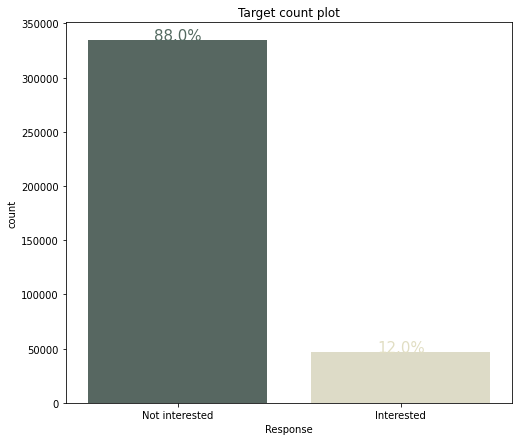

In [ ]:
# Plot
fig, ax = plt.subplots(figsize = (8,7))

palette=['#546A61', '#E1DEC3']

sns.countplot(train['Response'], ax = ax, palette= palette)

plt.title('Target count plot')

ax.set_xticklabels(['Not interested','Interested'])

for i in range(2):
  ant = train['Response'].value_counts(normalize = True)[i].round(2) * 100
  count = train['Response'].value_counts()[i]
  ax.annotate(str(ant)+'%', xy = (i, count),  ha='center', fontsize = 15, color = palette[i])

심각한 Imbalanced 데이터를 보여준다. train 데이터에서 전체의 88%가 자동차보험에 관심을 보이지 않았으며, 오직 12%만 관심을 보여주었다. 우리의 최종목표는 자동차 보험에 관심이 있는사람과 없는사람을 잘 분류하는것에 있다. 그렇기 때문에 학습을 하거나, 평가지수를 선택할 때 더 주의를 기울어야겠다. 

### 1. Baseline model

In [ ]:
from sklearn.metrics import accuracy_score
target = 'Response'

# 최빈값
baseline =  train[target].mode()[0]

# 예측값
y_pred = [baseline] * len(train[target]) # 모두 0(Not interested)로 예측

print('Baseline model 정확도(Accuracy) :', int(accuracy_score(train[target], y_pred).round(2) * 100),'%')

Baseline model 정확도(Accuracy) : 88 %


imbalanced 데이터에서 가장 문제점중의 하나는 위에 보이는 결과를 통해 확인 할 수 있다. 아무 근거없이 그냥 train 데이터내에서 88%를 차지하는 0의 값으로 모두를 예측했을 때 정확도(Accuracy)가 88%가 나옴을 알 수 있다. 여기서 말하는 정확도(Accuracy)는 전체 예측중에서 실제값과 예측값이 같은 비율을 의미한다. 따라서, 모델의 평가지표로 정확도를 사용하면 모델의 성능을 제대로 파악하기 힘듬을 알 수 있다. 따라서, 정확도 대신 다른 평가지표를 사용하여 모델을 평가할 것이다. 

## 4.Gender

In [ ]:
sns.set_style('white')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



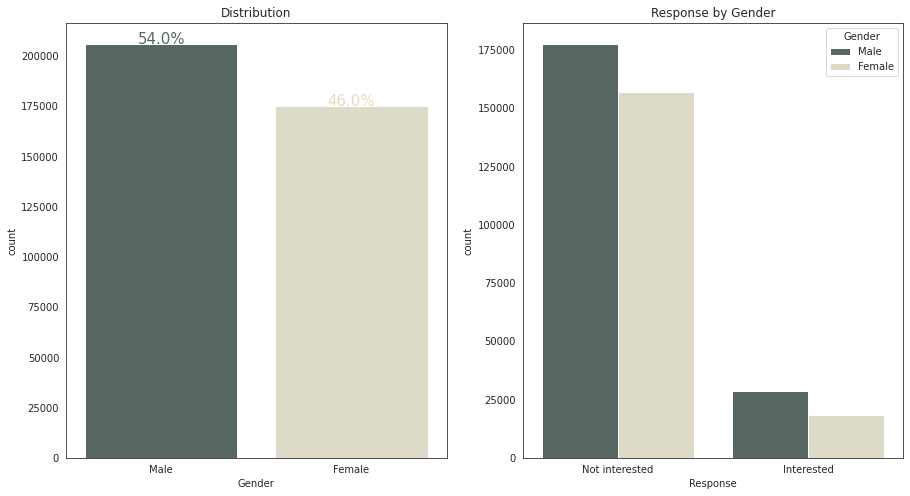

In [ ]:
# Gender plot
fig, axes = plt.subplots(1,2, figsize = (15,8))

pal = ['#C2C7CD', '#24303F']
sns.countplot(train['Gender'], palette = palette, ax = axes[0])
axes[0].set_title("Distribution")
for i in range(2):
  ant = train['Gender'].value_counts(normalize = True)[i].round(2) * 100
  count = train['Gender'].value_counts()[i]
  axes[0].annotate(str(ant)+'%', xy = (i, count),  ha='center', fontsize = 15, color = palette[i])

sns.countplot(train['Response'], hue = train['Gender'], palette=palette, ax = axes[1])
plt.title("Response by Gender")
axes[1].set_xticklabels(['Not interested','Interested'])
plt.show()

train 데이터 내에서 남자의 비율은 54%이며, 여자의 비율을 46%로 남자가 조금 많다. 

## 5.Age

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Age Boxplot')

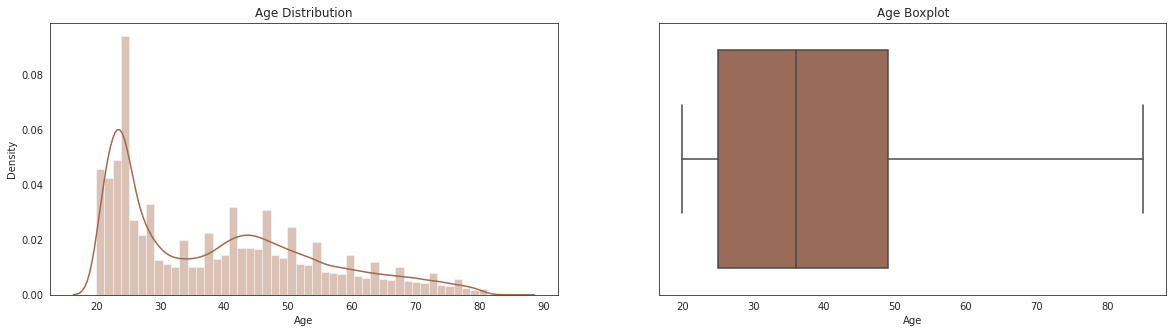

In [ ]:
# Age plot
f,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,5))
axes = ax.flatten()
sns.distplot(train['Age'], ax = axes[0], color='#A3684D')
axes[0].set_title('Age Distribution')
sns.boxplot(train['Age'], ax = axes[1], color='#A3684D')
plt.title('Age Boxplot')

주로 20대와 40대 사이에 만히 분포 하고 있으며, right-skewed한 형태를 보여주고있다. 박스 플랏을 보면 이상치는 없는듯하다. 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Response by Driving License')

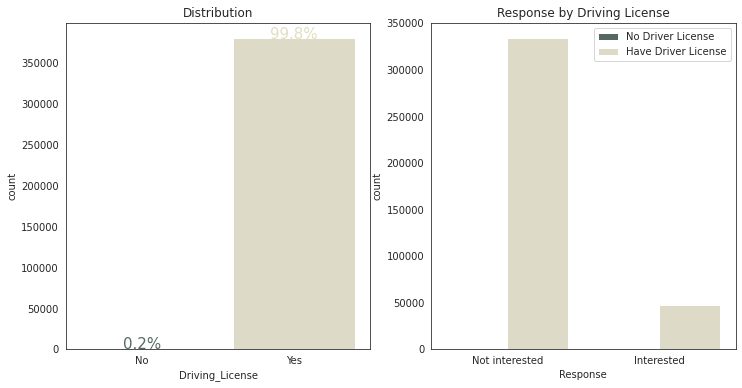

In [ ]:
# Driving_License plot
f,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))

# 1st plot
sns.countplot(train['Driving_License'],ax = axes[0],palette = palette)
axes[0].set_title("Distribution")
axes[0].set_xticklabels(['No','Yes'])
for i in range(2):
  ant = train['Driving_License'].value_counts(normalize = True)[i].round(3) * 100
  count = train['Driving_License'].value_counts()[i]
  axes[0].annotate(str(ant)+'%', xy = (i, count),  ha='center', fontsize = 15, color = palette[i])

# 2nd plot
sns.countplot(train['Response'], hue = train['Driving_License'], ax =axes[1], palette=palette)
plt.legend(labels = ['No Driver License', 'Have Driver License'])
axes[1].set_xticklabels(['Not interested','Interested'])
plt.title("Response by Driving License")

train 데이터 전체의 99.8%가 면허증을 보유하고 있다. 

## 6.Region_Code

In [ ]:
train['Region_Code'].unique()

array([28.,  3., 11., 41., 33.,  6., 35., 50., 15., 45.,  8., 36., 30.,
       26., 16., 47., 48., 19., 39., 23., 37.,  5., 17.,  2.,  7., 29.,
       46., 27., 25., 13., 18., 20., 49., 22., 44.,  0.,  9., 31., 12.,
       34., 21., 10., 14., 38., 24., 40., 43., 32.,  4., 51., 42.,  1.,
       52.])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Region_Code Boxplot')

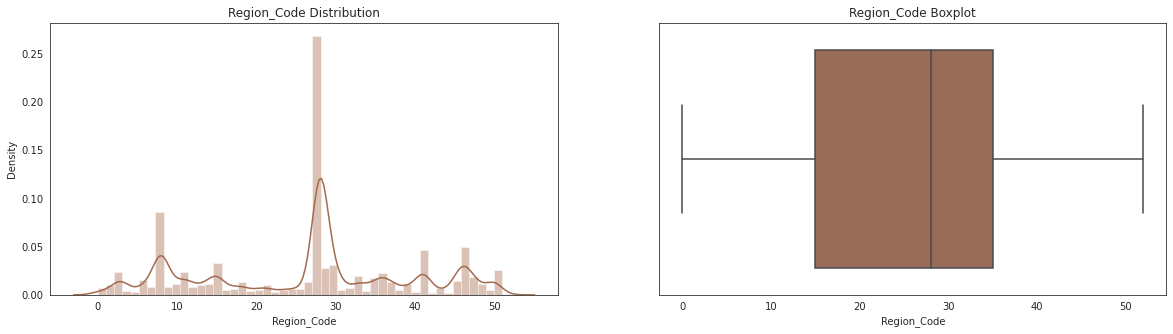

In [ ]:
# Region_Code plot
f,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,5))
axes = ax.flatten()
sns.distplot(train['Region_Code'], ax = axes[0], color='#A3684D')
axes[0].set_title('Region_Code Distribution')
sns.boxplot(train['Region_Code'], ax = axes[1], color='#A3684D')
plt.title('Region_Code Boxplot')

In [ ]:
# Value_counts
train['Region_Code'].mode()

0    28.0
dtype: float64

지역에 따라 고객들의 분포가 많이 나뉨을 알 수 있다. Region_Code가 28인 지역이 전체의 약 28%로 가장 많은 비율을 차지하고 있다.

Text(0.5, 1.0, 'Number of people interested by Region_Code')

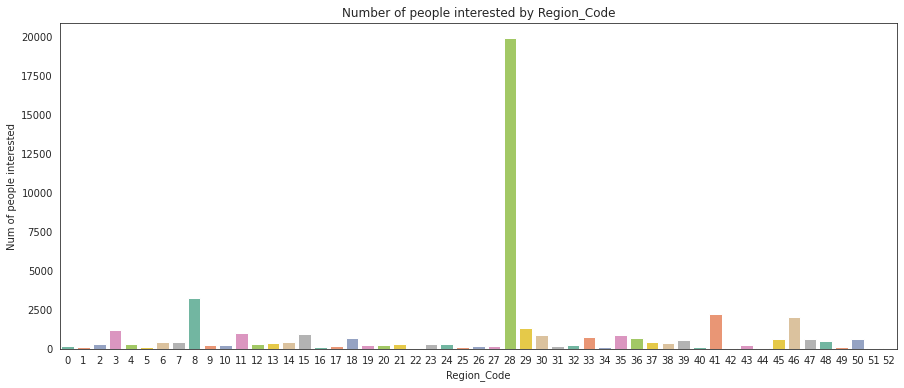

In [ ]:
# which Region_code has the highest num of interested people
region = train.groupby('Region_Code')[target].sum().reset_index()
region['Region_Code'] = region['Region_Code'].astype(int)
abs
plt.figure(figsize = (15,6))
sns.barplot(x = 'Region_Code', y = 'Response', data = region, palette='Set2')
plt.ylabel('Num of people interested')
plt.title('Number of people interested by Region_Code')

자동차보험에 관심이 있는사람들의 수를 Region_Code로 분류하여 나타낸 그래프이다. 마찬가지로, 28 지역코드에서 가장많은 사람이 분포하고 있음을 알 수 있다.

## 7.Previously_Insured

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Response by Previously Insured')

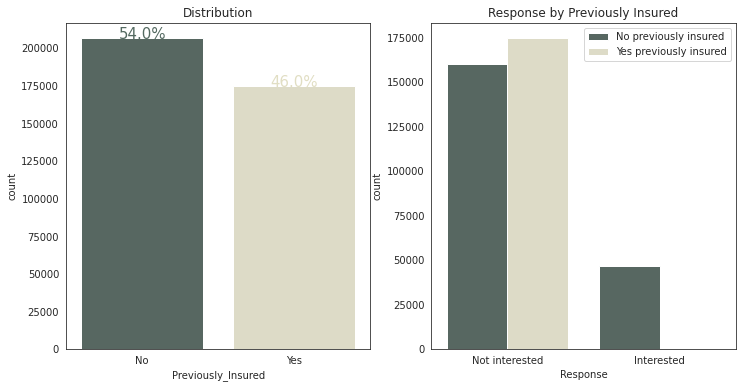

In [ ]:
# Driving_License plot
f,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))

# 1st plot
sns.countplot(train['Previously_Insured'],ax = axes[0],palette = palette)
axes[0].set_title("Distribution")
axes[0].set_xticklabels(['No','Yes'])
for i in range(2):
  ant = train['Previously_Insured'].value_counts(normalize = True)[i].round(2) * 100
  count = train['Previously_Insured'].value_counts()[i]
  axes[0].annotate(str(ant)+'%', xy = (i, count),  ha='center', fontsize = 15, color = palette[i])

# 2nd plot
sns.countplot(train['Response'], hue = train['Previously_Insured'], ax =axes[1], palette=palette)
plt.legend(labels = ['No previously insured', 'Yes previously insured'])
axes[1].set_xticklabels(['Not interested','Interested'])
plt.title("Response by Previously Insured")

> 자동차보험의 여부를 나타내는 `Previously_Insured`의 분포를 나타내는 그래프이다. 전체의 54%가 자동차보험에 가입하지 않았으며, 46%가 자동차보험을 이미 보유하고 있다. 당연하게도, 자동차보험을 이미 보유하고 있는 사람들은 새로운 자동차보험에 전혀 관심을 보이지 않는다. 

## 8.Vehicle_Age

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Response by Vehicle Age')

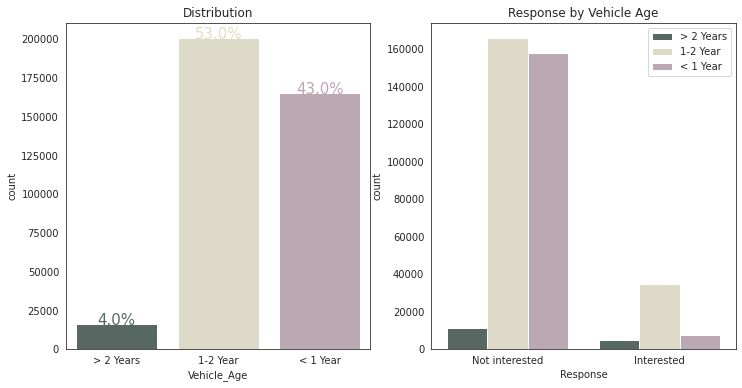

In [ ]:
# Vehicle_Age plot
f,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
palette = palette + ['#C0A4B4']

# 1st plot
sns.countplot(train['Vehicle_Age'],ax = axes[0],palette = palette)
axes[0].set_title("Distribution")
for i in range(3):
  ant = train['Vehicle_Age'].value_counts(normalize = True)[i].round(2) * 100
  count = train['Vehicle_Age'].value_counts()[i]
  if i == 0:
    axes[0].annotate(str(ant)+'%', xy = (1, count),  ha='center', fontsize = 15, color = palette[1])
  elif i == 1:
    axes[0].annotate(str(ant)+'%', xy = (2, count),  ha='center', fontsize = 15, color = palette[2])
  else:
    axes[0].annotate(str(ant)+'%', xy = (0, count),  ha='center', fontsize = 15, color = palette[0])

# 2nd plot
sns.countplot(train['Response'], hue = train['Vehicle_Age'], ax =axes[1], palette=palette)
plt.legend(labels = ['> 2 Years', '1-2 Year', '< 1 Year'])
axes[1].set_xticklabels(['Not interested','Interested'])
plt.title("Response by Vehicle Age")

train 데이터셋에서 자동차 연식에 따른 분포를 나타내는 그래프이다. 1~2년의 자동차 연식을 가진 사람들이 절반이상이며, 그 다음으로 1년 미만은 43%, 마지막으로 2년이상 자동차연식을 가진사람은 4%로 가장 적다. 그 중에서도 1년과 2년사이의 자동차 연식을 가진 사람들이 자동차보험에 상대적으로 관심이 높은걸 알 수 있다.

## 9.Vehicle_Damage

In [ ]:
train['Vehicle_Damage'].value_counts(normalize = True)

Yes    0.504877
No     0.495123
Name: Vehicle_Damage, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Response by Vehicle Damgage')

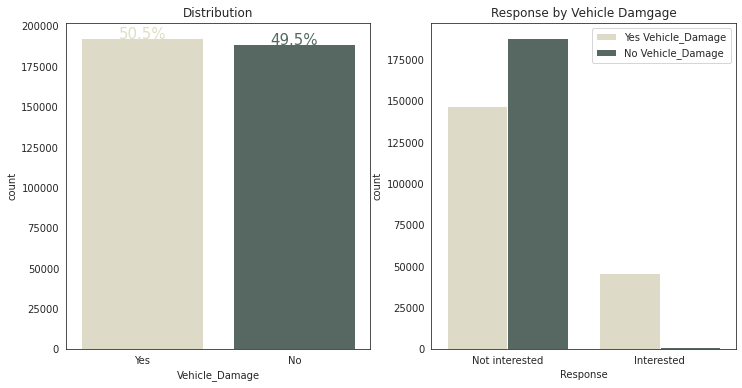

In [ ]:
# Vehicle_Damage plot
f,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))

# 1st plot
plt.title("Count plot of Vehicle_Damage vs Response")
sns.countplot(train['Vehicle_Damage'],ax = axes[0],palette = ['#E1DEC3','#546A61'])
axes[0].set_title("Distribution")
axes[0].set_xticklabels(['Yes','No'])
for i in range(2):
  if i == 0:
    ant = train['Vehicle_Damage'].value_counts(normalize = True)[1].round(3) * 100
    count = train['Vehicle_Damage'].value_counts()[1]
    axes[0].annotate(str(ant)+'%', xy = (1, count),  ha='center', fontsize = 15, color = palette[0])
  else :
    ant = train['Vehicle_Damage'].value_counts(normalize = True)[0].round(3) * 100
    count = train['Vehicle_Damage'].value_counts()[0]
    axes[0].annotate(str(ant)+'%', xy = (0, count),  ha='center', fontsize = 15, color = palette[1])

# 2nd plot
sns.countplot(train['Response'], hue = train['Vehicle_Damage'], ax =axes[1], palette=['#E1DEC3','#546A61'])
plt.legend(labels = ['Yes Vehicle_Damage', 'No Vehicle_Damage'])
axes[1].set_xticklabels(['Not interested','Interested'])
plt.title("Response by Vehicle Damgage")

## 10.Annual_Premium

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Annual_Premium Boxplot')

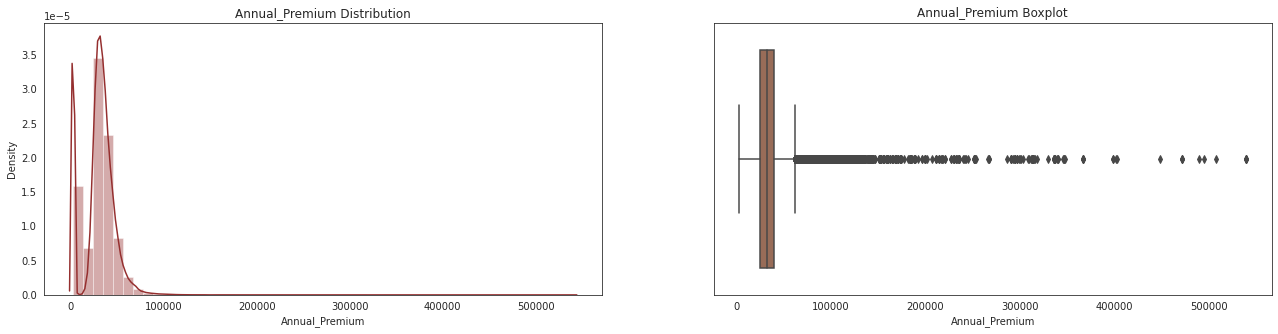

In [ ]:
# Annual_Premium
f,ax = plt.subplots(nrows=1,ncols=2,figsize=(22,5))
axes = ax.flatten()
sns.distplot(train['Annual_Premium'], ax = axes[0], color='#952F2F')
axes[0].set_title('Annual_Premium Distribution')
sns.boxplot(train['Annual_Premium'], ax = axes[1], color='#A3684D')
plt.title('Annual_Premium Boxplot')

## 11.Policy_Sales_Channel

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Policy_Sales_Channel Boxplot')

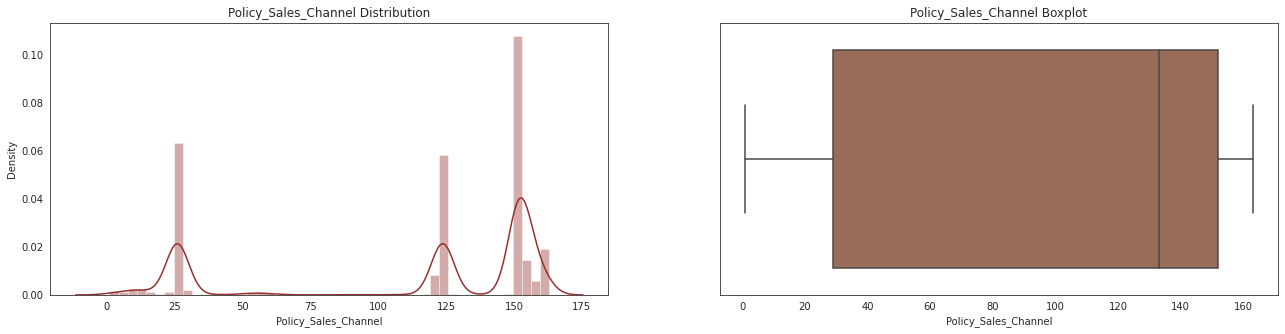

In [ ]:
# Policy_Sales_Channel
f,ax = plt.subplots(nrows=1,ncols=2,figsize=(22,5))
axes = ax.flatten()
sns.distplot(train['Policy_Sales_Channel'], ax = axes[0], color='#952F2F')
axes[0].set_title('Policy_Sales_Channel Distribution')
sns.boxplot(train['Policy_Sales_Channel'], ax = axes[1], color='#A3684D')
plt.title('Policy_Sales_Channel Boxplot')

In [ ]:
train['Policy_Sales_Channel'].unique()

array([ 26., 152., 160., 124.,  14.,  13.,  30., 156., 163., 157., 122.,
        19.,  22.,  15., 154.,  16.,  52., 155.,  11., 151., 125.,  25.,
        61.,   1.,  86.,  31., 150.,  23.,  60.,  21., 121.,   3., 139.,
        12.,  29.,  55.,   7.,  47., 127., 153.,  78., 158.,  89.,  32.,
         8.,  10., 120.,  65.,   4.,  42.,  83., 136.,  24.,  18.,  56.,
        48., 106.,  54.,  93., 116.,  91.,  45.,   9., 145., 147.,  44.,
       109.,  37., 140., 107., 128., 131., 114., 118., 159., 119., 105.,
       135.,  62., 138., 129.,  88.,  92., 111., 113.,  73.,  36.,  28.,
        35.,  59.,  53., 148., 133., 108.,  64.,  39.,  94., 132.,  46.,
        81., 103.,  90.,  51.,  27., 146.,  63.,  96.,  40.,  66., 100.,
        95., 123.,  98.,  75.,  69., 130., 134.,  49.,  97.,  38.,  17.,
       110.,  80.,  71., 117.,  58.,  20.,  76., 104.,  87.,  84., 137.,
       126.,  68.,  67., 101., 115.,  57.,  82.,  79., 112.,  99.,  70.,
         2.,  34.,  33.,  74., 102., 149.,  43.,   

특정 경로를 통해서 보험에 가입한 경우가 몇몇 있다. 이상치는 존재하지 않는다.

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]),
 <a list of 155 Text major ticklabel objects>)

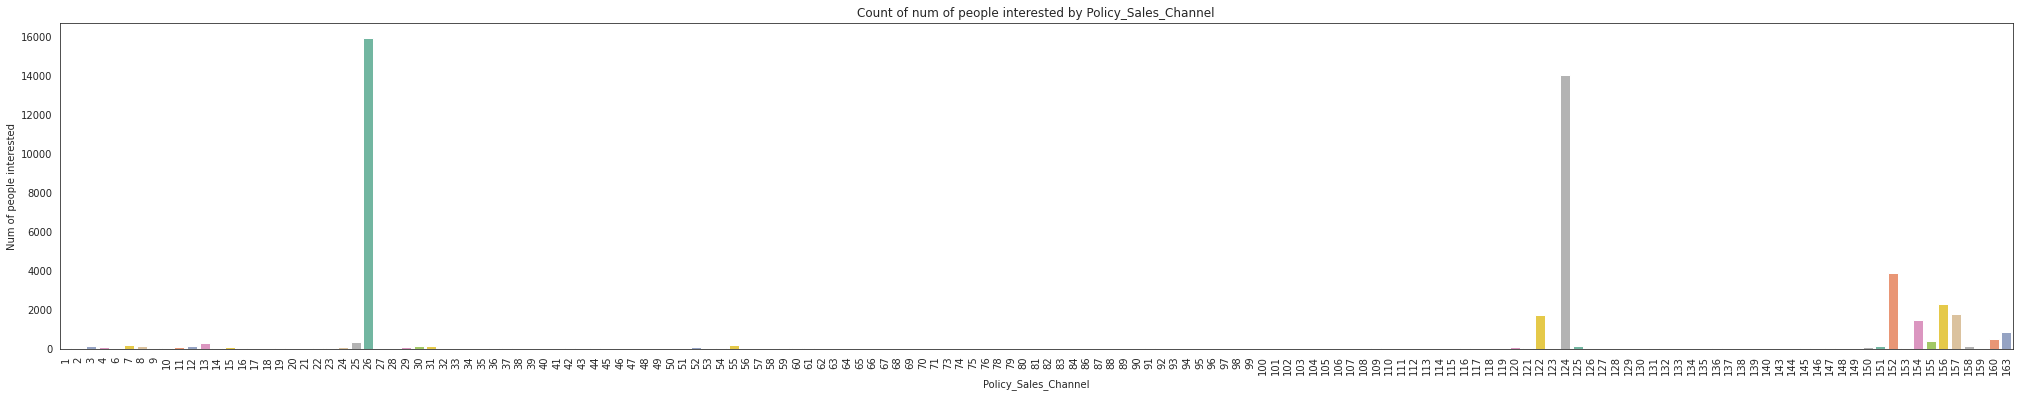

In [ ]:
# which Region_code has the highest num of interested people
region = train.groupby('Policy_Sales_Channel')[target].sum().reset_index()
region['Policy_Sales_Channel'] = region['Policy_Sales_Channel'].astype(int)
abs
plt.figure(figsize = (35,6))
sns.barplot(x = 'Policy_Sales_Channel', y = 'Response', data = region, palette='Set2')
plt.ylabel('Num of people interested')
plt.title('Count of num of people interested by Policy_Sales_Channel')
plt.xticks(rotation = 90)

보험에 가입하게 된 경로에 따라, 자동차 보험에 관심이 있는 사람이 많음음 알 수 있다. 26, 124는 위의 분포 그래프와 비슷하지만, 152는 전혀 다른 양상을 보여준다.

## 12.Vintage

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Vintage Boxplot')

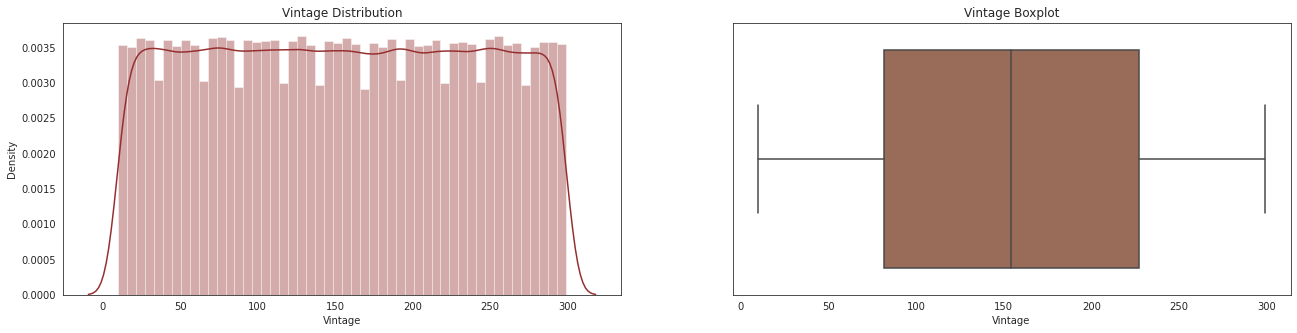

In [ ]:
# vintage plot
f,axes = plt.subplots(nrows=1,ncols=2,figsize=(22,5))
sns.distplot(train['Vintage'], color='#952F2F', ax = axes[0])
axes[0].set_title('Vintage Distribution')
sns.boxplot(train['Vintage'], ax=axes[1], color='#A3684D')
plt.title('Vintage Boxplot')

보험회사와 관계를 가진 총 시간을 나타내는 그래프이다. 전반적으로 고르게 분포 되어있고, 이상치는 존재하지 않는다. 

## 13.Correlation

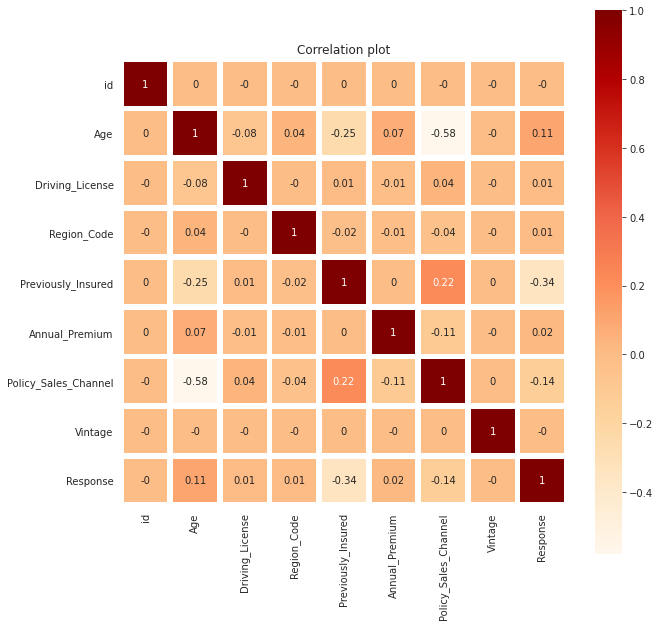

In [ ]:
# cor plot
plt.figure(figsize=(10,10))
plt.title("Correlation plot")
sns.heatmap(train.corr().round(2), linewidths=5, annot=True, square=True, annot_kws={'size': 10}, cmap='OrRd')

타겟 특성을 제와한 특성들 중에 서로 상관관계가 큰 특성들은 없어 보인다. 

# Feature Engineering

In [ ]:
# Encoding
train['is_train'] = 1               
test['is_train'] = 0
test['Response'] = None
df = pd.concat((train,test)) # 파이프라인을 사용하지 않고 encoder만 따로 적용하기 위해서

# 확인
print(df.shape)
df.head()

(508146, 13)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,1
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,1
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,1


## 1.id 제거

고유값인 id를 제거함

In [ ]:
# Drop id
df = df.drop('id', axis = 1)
print(df.shape)

(508146, 12)


## 2.이상치 제거

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Annual_Premium Boxplot')

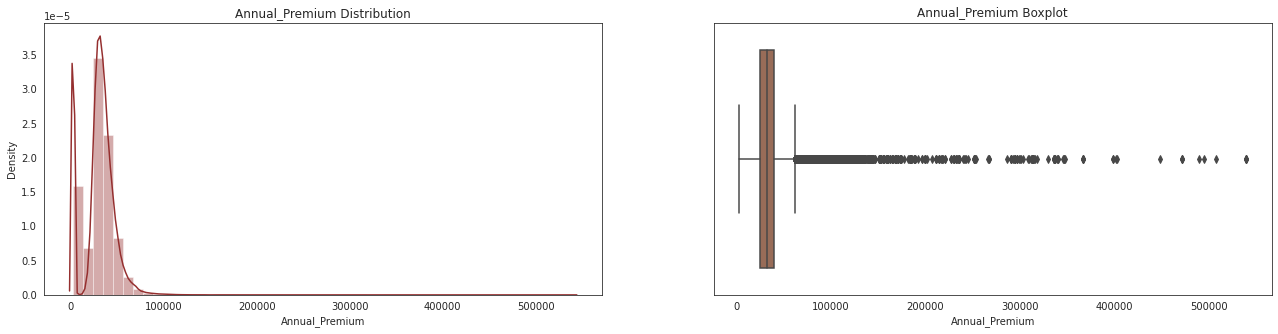

In [ ]:
# Annual_Premium
f,ax = plt.subplots(nrows=1,ncols=2,figsize=(22,5))
axes = ax.flatten()
sns.distplot(train['Annual_Premium'], ax = axes[0], color='#952F2F')
axes[0].set_title('Annual_Premium Distribution')
sns.boxplot(train['Annual_Premium'], ax = axes[1], color='#A3684D')
plt.title('Annual_Premium Boxplot')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Annual_Premium Boxplot')

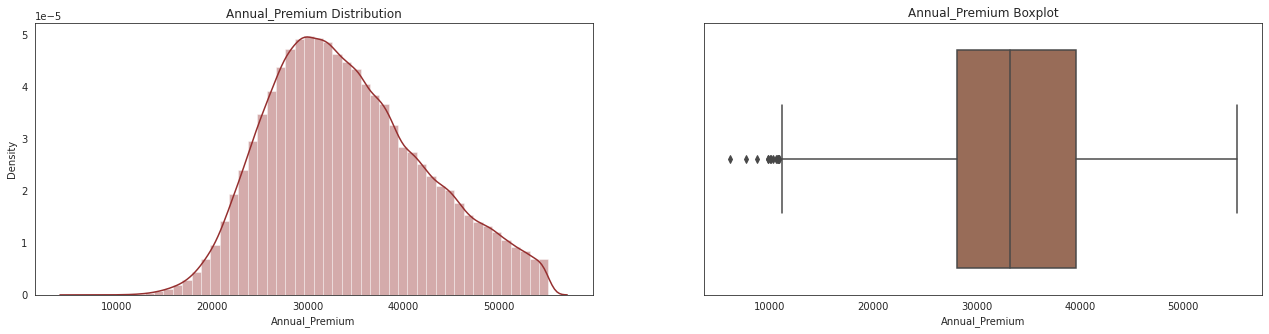

In [ ]:
# 이상치 제거 후 결과 확인
plot = train.loc[(train['Annual_Premium'] < np.quantile(train['Annual_Premium'], 0.95)) & (train['Annual_Premium'] > np.quantile(train['Annual_Premium'], 0.05))]
f,ax = plt.subplots(nrows=1,ncols=2,figsize=(22,5))
axes = ax.flatten()
sns.distplot(plot['Annual_Premium'], ax = axes[0], color='#952F2F')
axes[0].set_title('Annual_Premium Distribution')
sns.boxplot(plot['Annual_Premium'], ax = axes[1], color='#A3684D')
plt.title('Annual_Premium Boxplot')

In [ ]:
# 이상치 상위 5%, 하위 5% 데이터 제거
df = df.loc[(df['Annual_Premium'] < np.quantile(df['Annual_Premium'], 0.95)) & (df['Annual_Premium'] > np.quantile(df['Annual_Premium'], 0.05))]
df.shape

(396249, 12)

## 3.숫자형 데이터

In [ ]:
from sklearn.preprocessing import StandardScaler
# Num_feature
num_cols = ['Age', 'Annual_Premium', 'Vintage']

# StandardScaler
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Result
print(df.shape)
df.head()

(396249, 12)


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train
0,Male,0.392342,1,28.0,0,> 2 Years,Yes,0.760015,26.0,0.749965,1,1
1,Male,2.470344,1,3.0,0,1-2 Year,No,-0.083866,26.0,0.343590,0,1
2,Male,0.587155,1,28.0,0,> 2 Years,Yes,0.496531,26.0,-1.520953,1,1
3,Male,-1.101221,1,11.0,1,< 1 Year,No,-0.683657,152.0,0.582634,0,1
4,Female,-0.581721,1,41.0,1,< 1 Year,No,-0.820645,152.0,-1.377526,0,1


> 숫자형 데이터의 경우, 표준화를 통해서 성능 향상을 기대해보았다.

## 4.범주형 데이터

In [ ]:
# Train / Test
train = df[df['is_train']==1]                             
test = df[df['is_train']==0]
train = train.drop(['is_train'],axis=1)              
test = test.drop(['is_train','Response'] ,axis=1)

# target (object to int)
train['Response'] = train['Response'].astype(int)  
train.head()

# Train Result
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,0.392342,1,28.0,0,> 2 Years,Yes,0.760015,26.0,0.749965,1
1,Male,2.470344,1,3.0,0,1-2 Year,No,-0.083866,26.0,0.343590,0
2,Male,0.587155,1,28.0,0,> 2 Years,Yes,0.496531,26.0,-1.520953,1
3,Male,-1.101221,1,11.0,1,< 1 Year,No,-0.683657,152.0,0.582634,0
4,Female,-0.581721,1,41.0,1,< 1 Year,No,-0.820645,152.0,-1.377526,0


In [ ]:
# Test Result
test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,-0.841471,1,11.0,1,< 1 Year,No,0.190597,152.0,-1.210196
1,Male,0.132592,1,28.0,0,1-2 Year,Yes,-0.056297,7.0,-0.516968
2,Male,0.587155,1,28.0,0,1-2 Year,Yes,0.710733,124.0,0.534825
3,Male,-0.906408,1,27.0,1,< 1 Year,Yes,0.382110,152.0,0.391399
5,Male,-1.036284,1,30.0,1,< 1 Year,No,0.729885,152.0,1.335622


In [ ]:
!pip install category_encoders
clear_output()

In [ ]:
# Cat features
cat_cols = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age','Vehicle_Damage','Region_Code','Policy_Sales_Channel']

# Ordinal Encoder
from category_encoders import OrdinalEncoder

enc = OrdinalEncoder()

train[cat_cols] = enc.fit_transform(train[cat_cols], y = train['Response'])

test[cat_cols] = enc.transform(test[cat_cols])

# Train Result
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0.392342,1,28.0,0,1,1,0.760015,26.0,0.749965,1
1,1,2.470344,1,3.0,0,2,2,-0.083866,26.0,0.343590,0
2,1,0.587155,1,28.0,0,1,1,0.496531,26.0,-1.520953,1
3,1,-1.101221,1,11.0,1,3,2,-0.683657,152.0,0.582634,0
4,2,-0.581721,1,41.0,1,3,2,-0.820645,152.0,-1.377526,0


In [ ]:
# Test Result
test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,1,-0.841471,1,11.0,1,3,2,0.190597,152.0,-1.210196
1,1,0.132592,1,28.0,0,2,1,-0.056297,7.0,-0.516968
2,1,0.587155,1,28.0,0,2,1,0.710733,124.0,0.534825
3,1,-0.906408,1,27.0,1,3,1,0.382110,152.0,0.391399
5,1,-1.036284,1,30.0,1,3,2,0.729885,152.0,1.335622


> 범주형 데이터의 경우 `OrdinalEncoder`를 사용하여서, 숫자형 데이터로 변환해주었다.

In [ ]:
# X, y
X = train.drop(target, axis = 1)
y = train[target]
X_test = test

# Train / Val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2,
                                                  stratify = y, shuffle = True)

간단한 feauture engineering 작업을 통하여, 데이터 전처리를 하였다. 그리고, train/validation 데이터셋으로 나누어 주었다.

# Modeling

## Baseline Model

In [ ]:
# confustion matrix plot function 
def plot_confusion_matrix(y_real, y_pred):
    cm = confusion_matrix(y_real, y_pred)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g')

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

In [ ]:
# 예측값
y_pred_bs = [0] * len(X_val)
y_prob_bs = [0] * len(X_val)

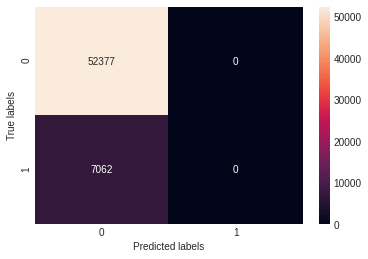

In [ ]:
# confusion matrix
plot_confusion_matrix(y_val, y_pred_bs)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred_bs))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     52377
           1       0.00      0.00      0.00      7062

    accuracy                           0.88     59439
   macro avg       0.44      0.50      0.47     59439
weighted avg       0.78      0.88      0.83     59439



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



> 베이스라인 모델로서 모든 예측값을 최빈 클래스로 하였을 때, 당연히 f1 점수는 0이다.

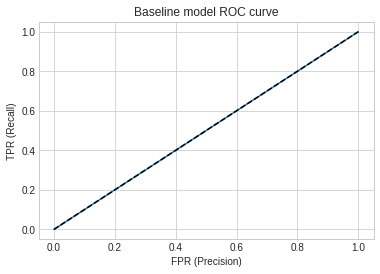

Area under curve (AUC):  0.5


In [ ]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-whitegrid')

# ROC curve
fpr, tpr, thr = roc_curve(y_val, y_prob_bs)

plt.title('Baseline model ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))

> 마찬가지로, AUC 점수 또한 최저 점수이다.

## 1. RandomForest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# # RandomForest Modeling
# rf = RandomForestClassifier(random_state=2, n_jobs = -1, class_weight='balanced')

# # param grid
# rf_grid ={
#     'criterion' : ['gini', 'entropy'],
#     'max_features': ['auto', 'sqrt'],
#     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
#     'min_samples_leaf': [1, 2, 4],
#     'min_samples_split': [2, 5, 10],
#     'n_estimators': [130, 180, 230]
# }

# # Tuning
# clf = RandomizedSearchCV(
#     rf,
#     rf_grid,
#     n_iter = 10,
#     cv = 4,
#     random_state = 2
# )

# # 학습
# clf.fit(X_train, y_train)

# # 예측
# y_pred_rf = clf.predict(X_val)
# y_prob_rf = clf.predict_proba(X_val)[:,1]

> `RandomizedSearchCV`를 통해서 하이퍼 파라미터 튜닝

In [ ]:
# Randomforest HyperParameter Tuning Result
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=60, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=230,
                       n_jobs=-1, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

# 학습
rf.fit(X_train, y_train)

# 예측
y_pred_rf = rf.predict(X_val)
y_prob_rf = rf.predict_proba(X_val)[:,1]

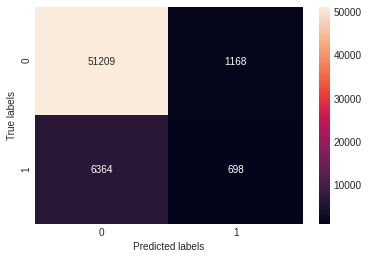

In [ ]:
# confusion matrix
plot_confusion_matrix(y_val, y_pred_rf)

In [ ]:
from sklearn.metrics import classification_report

# Classification Report
print (classification_report(y_val, y_pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     52377
           1       0.37      0.10      0.16      7062

    accuracy                           0.87     59439
   macro avg       0.63      0.54      0.54     59439
weighted avg       0.83      0.87      0.84     59439



> 1에 대한 예측을 하기 시작함, 하지만 그 횟수가 너무 적고 재현율이 낮음

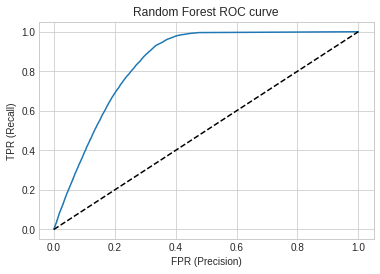

Area under curve (AUC):  0.8461116710398205


In [ ]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-whitegrid')

# ROC curve
fpr, tpr, thr = roc_curve(y_val, y_prob_rf)

plt.title('Random Forest ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))

> 하지만 AUC점수는 좋은 성능을 보여줌.

## XGBoost

In [ ]:
# np.random.seed(666)
# sampler = TPESampler(seed=0)

# 최적화 시킬 모델과 하이퍼파라미터 설정
# def create_model(trial):
#     max_depth = trial.suggest_int("max_depth", 2, 20)
#     n_estimators = trial.suggest_int("n_estimators", 1, 400)
#     learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
#     gamma = trial.suggest_uniform('gamma', 0.0000001, 1)
#     scale_pos_weight = trial.suggest_int("scale_pos_weight", 1, 20)
#     model = XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, gamma=gamma, scale_pos_weight=scale_pos_weight, random_state=0)
#     return model

# 최적화 하는 점수를 구하는 함수를 작성
# def objective(trial):
#     model = create_model(trial)
#     model.fit(X_train, y_train)
#     preds = model.predict(X_val)
#     score = f1_score(y_val, preds)
#     return score

# objective에서 설정한 함수의 최대값을 구하는 방향으로 최적화 진행
# study = optuna.create_study(direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=100)

# 최적화 결과 확인
# xgb_params = study.best_params
# xgb_params['random_state'] = 0
# xgb = XGBClassifier(**xgb_params)
# xgb.fit(X_train, y_train)

> `optuna`를 사용한 하이퍼 파라미터 튜닝

In [ ]:
# xgb hyperparameter tuning result
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              gamma=0.0012894603636011376, learning_rate=0.11574102977184302,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=347, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=4, seed=None, silent=None,
              subsample=1, verbosity=1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)
y_prob_xgb = xgb.predict_proba(X_val)[:,1]

> 시간이 오래걸려서, 최적화 결과를 따로 정의함.

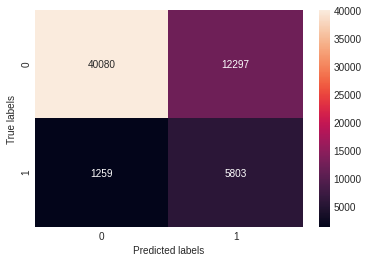

In [ ]:
plot_confusion_matrix(y_val, xgb.predict(X_val))

In [ ]:
print (classification_report(y_val, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86     52377
           1       0.32      0.82      0.46      7062

    accuracy                           0.77     59439
   macro avg       0.65      0.79      0.66     59439
weighted avg       0.89      0.77      0.81     59439



> 재현율이 0.82로 증가함, 게다가 1로 예측하는 횟수가 `RandomForest`모델보다 엄청나게 증가함.

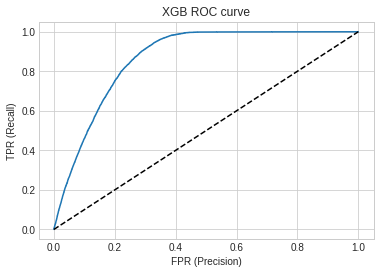

Area under curve (AUC):  0.8658406500262159


In [ ]:
# ROC curve
fpr, tpr, thr = roc_curve(y_val, y_prob_xgb)

plt.title('XGB ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))

> 마찬가지로, AUC 점수 또한 `RandomForest`모델보다 증가했다.

## LGBM

In [ ]:
from lightgbm import LGBMClassifier

# 모델
lgb = LGBMClassifier(boosting_type='gbdt',n_estimators=500,depth=10,learning_rate=0.04,objective='binary',metric='f1',is_unbalance=True,
                 colsample_bytree=0.5,reg_lambda=2,reg_alpha=2,random_state=2,n_jobs=-1)

# 학습
lgb= lgb.fit(X_train, y_train,eval_metric='auc',eval_set=(X_val , y_val),verbose=50,categorical_feature=cat_cols,early_stopping_rounds= 50)

# 예측
y_pred_lgb = lgb.predict(X_val)
y_prob_lgb = lgb.predict_proba(X_val)[:, 1]

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['Driving_License', 'Gender', 'Policy_Sales_Channel', 'Previously_Insured', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage']



Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.864818
[100]	valid_0's auc: 0.865783
[150]	valid_0's auc: 0.865933
[200]	valid_0's auc: 0.86618
[250]	valid_0's auc: 0.866178
[300]	valid_0's auc: 0.86612
Early stopping, best iteration is:
[260]	valid_0's auc: 0.86621


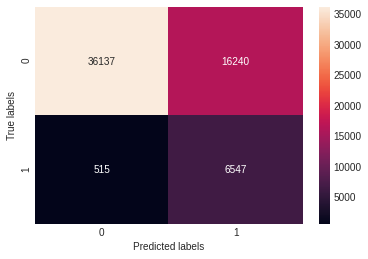

In [ ]:
# confusion matrix
plot_confusion_matrix(y_val, y_pred_lgb)

In [ ]:
# classification Report
print (classification_report(y_val, y_pred_lgb))

              precision    recall  f1-score   support

           0       0.99      0.69      0.81     52377
           1       0.29      0.93      0.44      7062

    accuracy                           0.72     59439
   macro avg       0.64      0.81      0.63     59439
weighted avg       0.90      0.72      0.77     59439



> 전체적으로, f1 score는 떨어졌지만 자동차보험에 관심이 있다고 예측한 횟수가 엄청 늘어났고 재현율이 0.93으로 엄청 좋아졌다.

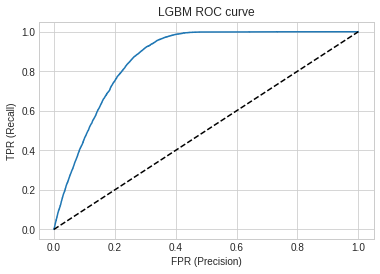

Area under curve (AUC):  0.8662098512447501


In [ ]:
# ROC curve
fpr, tpr, thr = roc_curve(y_val, y_prob_lgb)

plt.title('LGBM ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))

> 마찬가지로, AUC 점수 또한 소폭 상승하였다.

보험사의 입장에서 생각을 해보았을 때, 물론 재현율 정밀도 모두 중요하지만 재현율에 더 가산점을 줘야한다. 예측이 틀린것보다, 자동차보험에 관심이 있는 사람을 놓쳐서는 안되기 때문이다. 따라서, 전반적인 **f1_score**는 `XGB`모델이 높지만, 재현율이 훨씬 높은 `LGBM`모델을 최종 예측 모델로 설정한다.

# Interpretation

최종 모델인 LGBM모델의 각기 다른 특성들이 주는 영향을 확인해보자.

## 1.Feature Importance
예측 모델에서 중요한 역할을 했던 특성들을 확인할 수 있다.

In [ ]:
# 라이브러리 설치
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
clear_output()

In [ ]:
# Permutation Importance Instance 생성
perm = PermutationImportance(lgb, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.0142 ± 0.0008,Region_Code
0.0124 ± 0.0004,Age
0.0071 ± 0.0003,Vehicle_Age
0.0013 ± 0.0001,Gender
0.0006 ± 0.0001,Vintage
0.0005 ± 0.0000,Driving_License
0.0002 ± 0.0002,Annual_Premium
-0.0133 ± 0.0007,Policy_Sales_Channel
-0.0638 ± 0.0011,Vehicle_Damage
-0.0661 ± 0.0011,Previously_Insured


> `LGBM`모델에서 가장 중요한 역할을 했던 특성은 **Region_code**, **Age**가 있다.

In [ ]:
# 불 필요 특성 제거 후 결과 확인
X_train_drop = X_train.drop(['Annual_Premium', 'Driving_License'], axis = 1)
X_val_drop = X_val.drop(['Annual_Premium', 'Driving_License'], axis = 1)

In [ ]:
from sklearn.metrics import roc_auc_score

# 학습
lgb.fit(X_train_drop, y_train)

# 예측
y_pred_lgb = lgb.predict(X_val_drop)
y_prob_lgb = lgb.predict_proba(X_val_drop)[:,1]

# 결과 확인
print('After Drop features LGBM AUC_score: ', roc_auc_score(y_val, y_prob_lgb))
print('After Drop features LGBM f1_score', f1_score(y_val, y_pred_lgb))

Optimized XGBClassifier accuracy:  0.863634768551923
Optimized XGBClassifier f1-score 0.4373056994818653


In [ ]:
# classification report
print (classification_report(y_val, y_pred_lgb))

              precision    recall  f1-score   support

           0       0.99      0.69      0.81     52377
           1       0.29      0.93      0.44      7062

    accuracy                           0.72     59439
   macro avg       0.64      0.81      0.62     59439
weighted avg       0.90      0.72      0.77     59439



> 불 필요한 특성들을 제거 후, `LGBM`모델에 적용하였을 때 성능 감소가 있어서 따로 제거하지 않고 사용하기로 했다.

## 2.PDP plot
하나의 특성이 모델에 전반적으로 어떻게 영향을 주었는지 확인할 수 있는 그래프이다.

In [ ]:
# library 설치
!pip install pdpbox
clear_output()

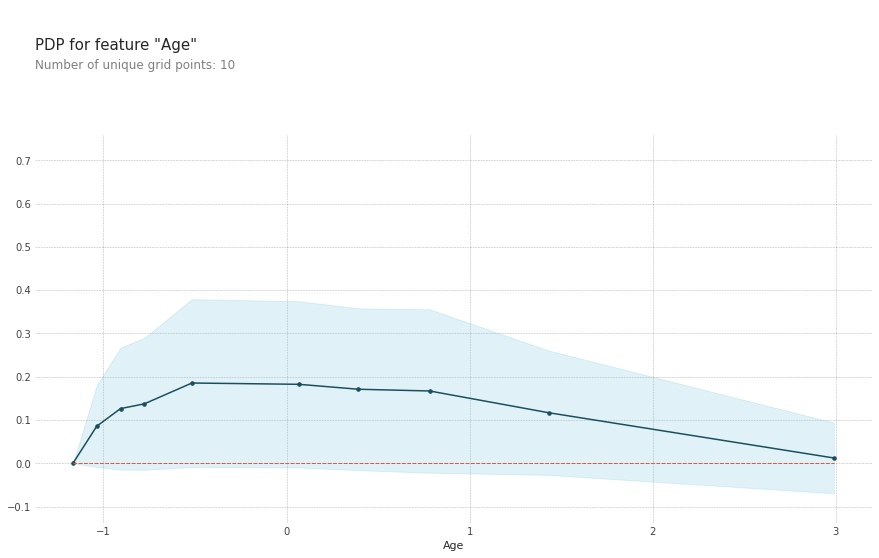

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot
import matplotlib.font_manager

# 본 학습 모델
lgb.fit(X_train, y_train)

# 두번째로 중요했던 특성인 나이
selected_feature = 'Age'

isolated = pdp_isolate(
    model=lgb, 
    dataset=X_val, 
    model_features=X_train.columns, 
    feature=selected_feature,
)
pdp_plot(isolated, feature_name=selected_feature);

> 나이가 가장 어린 구간을 보면 특정 나이까지 자동차보험에 관심이 증가하다가, 그 이후로는 계속 자동차 보험에 관심이 하락하고 있음을 알 수 있다.

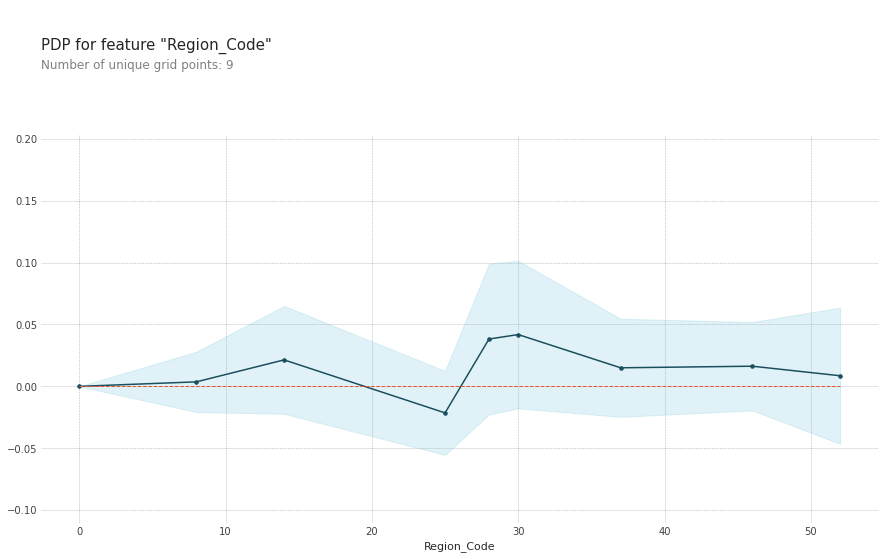

In [ ]:
# 첫번째로 중요했던 특성 Region_Code
selected_feature = 'Region_Code'

# pdp plot
isolated = pdp_isolate(
    model=lgb, 
    dataset=X_val, 
    model_features=X_train.columns, 
    feature=selected_feature,
)
pdp_plot(isolated, feature_name=selected_feature);

> 굉장히 불규칙적인 그래프임을 확인 할 수 있다. 30의 근처의 지역에서는 자동차보험에 대한 관심이 많지만, 반대로 25 근처의 지역에서는 자동차 보험에 대한 관심이 적다는것을 알 수 있다.

모델 해석을 통해 얻을 수 있는 결과는 다음과 같다.
1. 20대에서 40대 사이의 사람들이 자동차 보험에 관심이 많다.
2. 특정 지역에 거주하는 사람들이 자동차 보험에 관심이 많다.

이 두가지 사실을 통해서, 좀 더 효과적인 마케팅이 가능하지 않을까 생각한다.

# 결론
어느 하나의 보험사의 데이터를 통해서 자동차 보험에도 관심이 있는지 없는지를 예측하는 모델을 설정해보았다. 그 과정에서 중요했던 평가지수들과 다양한 시각화를 통하여 최종 모델을 설정하는 과정을 설명하려 하였다. 그 결과는 가장 높은 **재현율**을 보여준 `LGBM`모델을 최종 예측 모델로 설정하였다. 보험사의 입장에서는 자동차 보험이 관심이 있는 사람들은 놓치면 엄청난 손해이기 때문에, 정밀도가 조금 낮더라도 재현율이 높은 모델을 최종 예측 모델로 설정하였다. 추가로, 최종모델의 특성들의 중요드를 분석하여 자동차 보험 마케팅에도 효과적인 전략을 제시 할 수 있었다. 특정 **나이**대와 특정 **지역**의 거주하는 사람들을 대상으로 전략적인 마케팅이 가능 할 것임을 알 수 있었다.